# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
import re 

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
#Cargar los datos
try:
    df_reviews = pd.read_csv('/Users/rodrigolopez/Downloads/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


Se puede apreciar que es un conjunto de datos de 17 columnas con 47,331 filas. 
El nombre de las columnas mantiene un formato adecuado.
Existen dos columnas con dos valores ausentes, debido a que esto no afecta al estudio exploratorio de datos y al entrenamiento del modelo, no se realizarán los ajustes.

Existen dos columnas con dos valores ausentes, debido a que esto no afecta al estudio exploratorio de datos y al entrenamiento del modelo, no se realizarán los ajustes.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

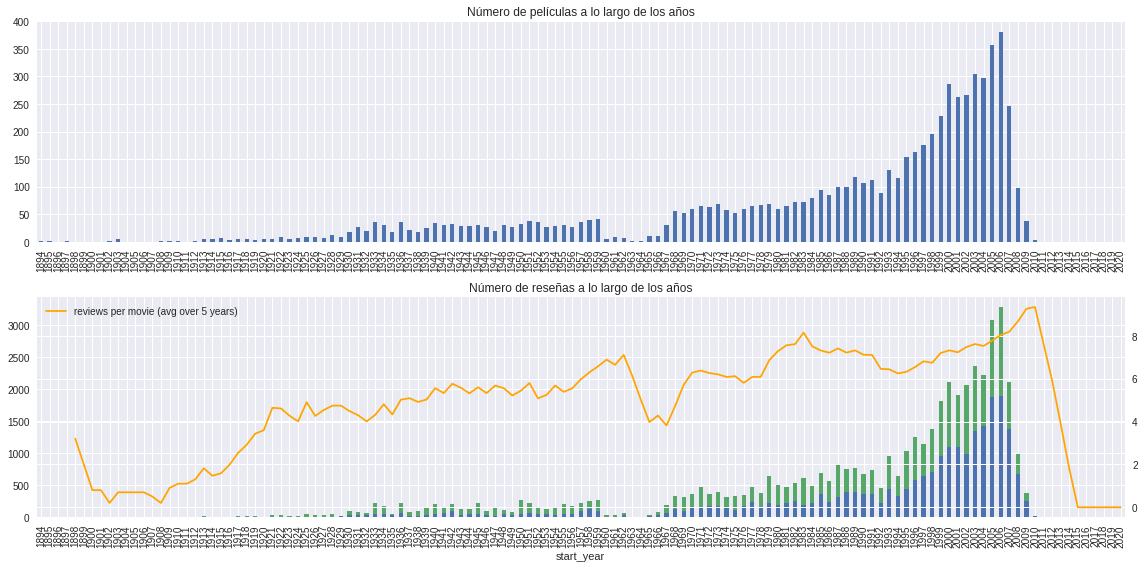

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

En el primer gráfico se puede apreciar como el número de películas a lo largo de los años ha aumentado, se tienen registro de las primeras películas en 1894 hasta el 2010. En 2006, hay un pico de un gran número de películas y este decae subitamente. 

En el siguiente gráfico se muestra la media movil de la película en una linea naranja. Se puede apreciar como el número de reseñas por película no cambia mucho, no se ven muchas variaciones con respecto a al número de películas por año.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

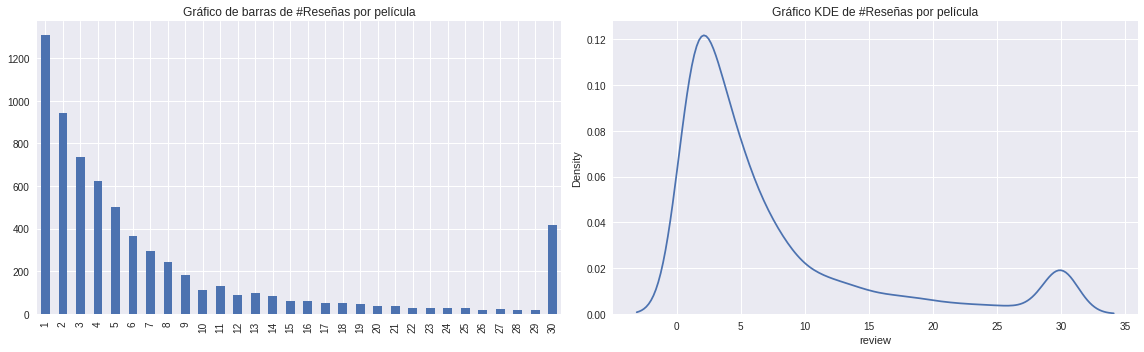

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

En el histograma se aprecian la cantidad de reviews por película. Por otro lado, la estimación de densidad de Kernel nos presenta un gráfico bastantante similar al histograma. Esto quiere decir que debe difererir la distribución del conteo exacto. 

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Se aprecia que las reviews positivas y negativas, tienden estar balanceadas a la mitad.

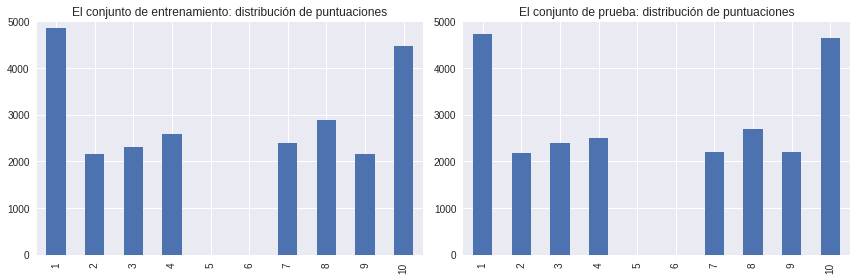

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Se puede apreciar el balanceo de la distribución de los datos para el conjunto de entrenamiento y prueba.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


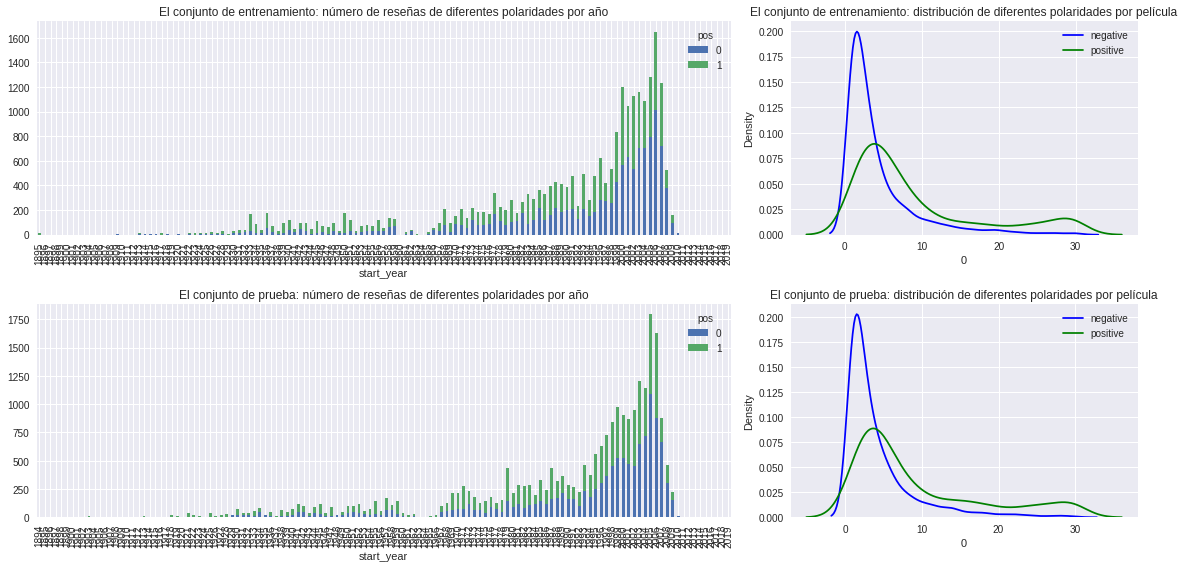

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

En lo gráficos se puede apreciar la distribución de las reseñas positivas y negativas. Se pudiera aparentar que hay un desquilibrio, pero no es asi, hay casi la misma cantidad de reseñas positivas y negativas. Esto ocurre para el conjunto de entranimiento y prueba.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [12]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [13]:
corpus = df_reviews["review"]

In [14]:
def clear_text(text):
    """La función remueve digitos y signos de puntuación; y
    cambia todo el texto a minusculas

    Args:
        text (string): texto que se desea limpiar

    Returns:
        string: texto sin digitos y signos de puntuación en minusculas
    """
    clean_text = re.sub(r'[^a-zA-z\']', ' ', text)
    clean_text = " ".join(clean_text.split())

    return clean_text.lower()


In [15]:
df_reviews['review_norm'] = df_reviews["review"].apply(clear_text)

In [16]:
df_reviews["review_norm"]

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47331, dtype: object

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

In [18]:
from sklearn.dummy import DummyClassifier

           train  test
Exactitud    0.5   0.5
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


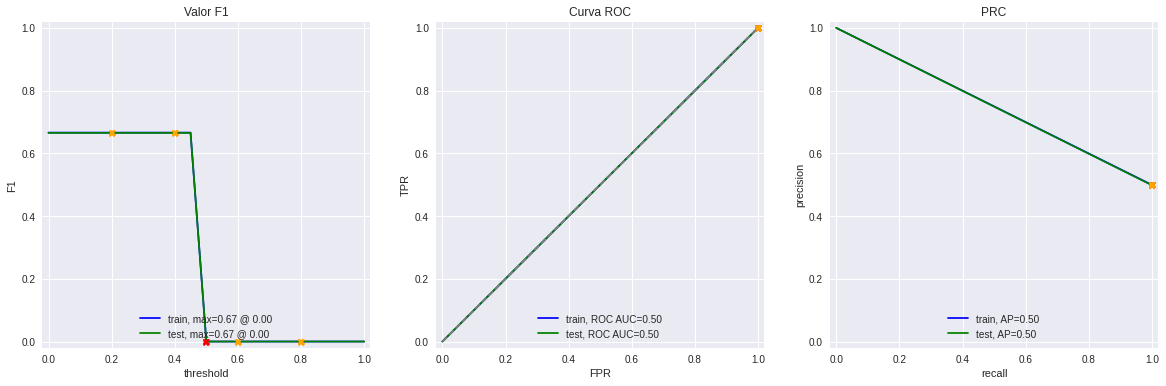

In [19]:
model = DummyClassifier(random_state= 931106)
model.fit(df_reviews_train["review_norm"], train_target)
predicted = model.predict(df_reviews_test["review_norm"]) 
evaluate_model(model, df_reviews_train["review_norm"], train_target, df_reviews_test["review_norm"], test_target)

Parece que el modelo dummy no funciona tan bien. Se puede apreciar que no esta haciendo ninguna predicción. Debido a su ROC AUC de 0.5, indica que las predicciones son aleatorias. De igual manera, se puede visualizar que existe un balanceo en los conjuntos, entre reseñas positivas y negativas

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import stopwords

In [21]:
#Corpus de los df
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test["review_norm"]

In [22]:
lemmatizer = WordNetLemmatizer()

In [23]:
def lemmatize(text):
    
    tokens = word_tokenize(text)
    
    lemmas = []
    for token in tokens:
        lemmas.append(lemmatizer.lemmatize(token))
    return ' '.join(lemmas)

In [24]:
nltk_train = corpus_train.apply(lemmatize)
nltk_test = corpus_test.apply(lemmatize)

In [25]:
#Conferversion TF-IDF
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf_nltk = TfidfVectorizer(stop_words=list(stop_words))
tf_idf_train_nltk = count_tf_idf_nltk.fit_transform(nltk_train)
tf_idf_test_nltk = count_tf_idf_nltk.transform(nltk_test)
print('El tamaño de la matriz TF-IDF train:', tf_idf_train_nltk.shape)
print('El tamaño de la matriz TF-IDF test:', tf_idf_test_nltk.shape)

El tamaño de la matriz TF-IDF train: (23796, 64447)
El tamaño de la matriz TF-IDF test: (23535, 64447)


           train  test
Exactitud   0.94  0.88
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


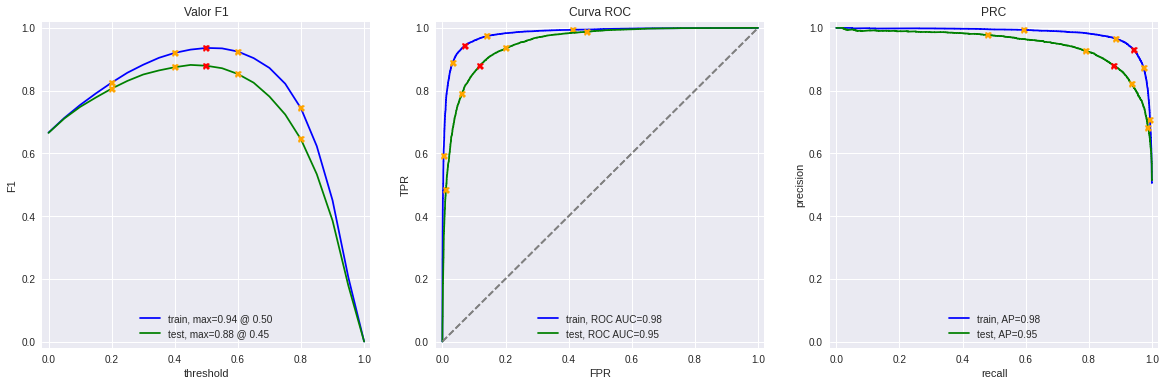

In [26]:
#Creación del modelo
model_1=LogisticRegression()
model_1.fit(tf_idf_train_nltk, train_target)
evaluate_model(model_1, tf_idf_train_nltk, train_target, tf_idf_test_nltk, test_target)

Se puede apreciar que se obtuvieron buenos resultados, con el modelo de regresión logísticas con lematización NLTK. La exactitud en el conjunto de prueba es del 88% y en el de entranamiento del 94; se puede considerar que no hay overfitting. Se tiene un valor de F1 de 88% en el conjunto de prueba, nos indica que tiene un buen nivel de predicción. La curva AUC-ROC nos el lineal, por consiguiente podemos asegurarnos que el modelo se encuentra prediciendo y no arroja resultados de manera aleatoria.

### Modelo 3 - spaCy, TF-IDF y LR

In [27]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [28]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [ ]:
spacy_train = corpus_train.apply(text_preprocessing_3)

In [ ]:
spacy_test = corpus_test.apply(text_preprocessing_3)


In [ ]:
#Conferversion TF-IDF
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf_spacy = TfidfVectorizer(stop_words=list(stop_words))
tf_idf_train_spacy = count_tf_idf_spacy.fit_transform(spacy_train)
tf_idf_test_spacy = count_tf_idf_spacy.transform(spacy_test)
print('El tamaño de la matriz TF-IDF train:', tf_idf_train_spacy.shape)
print('El tamaño de la matriz TF-IDF test:', tf_idf_test_spacy.shape)

In [ ]:
#Creación del modelo
model_2=LogisticRegression()
model_2.fit(tf_idf_train_spacy, train_target)
evaluate_model(model_2, tf_idf_train_spacy, train_target, tf_idf_test_spacy, test_target)

Se puede apreciar que se obstuvieron buenos resultados, con el modelo de regresión logística con lematización spacy. La exactitud en el conjunto de prueba es del 88% y en el de entranamiento del 93%; se puede considerar que no hay overfitting. Se tiene un valor de F1 de 88% en el conjunto de prueba, lo cual indica que tiene un buen nivel de predicción. La curva AUC-ROC no es lineal, por consiguiente podemos asegurarnos que el modelo se encuentra prediciendo y no arroja resultados de manera aleatoria.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
#Creación del modelo
model_3=LGBMClassifier()
model_3.fit(tf_idf_train_spacy, train_target)
evaluate_model(model_3, tf_idf_train_spacy, train_target, tf_idf_test_spacy, test_target)

Se puede apreciar que se obstuvieron buenos resultados, con el modelo de LightGBM con lematización spacy. La exactitud en el conjunto de prueba es del 86% y en el de entranamiento del 91%; se puede considerar que no hay overfitting. Se tiene un valor de F1 de 91% en el conjunto de prueba, lo cual indica que tiene un buen nivel de predicción. La curva AUC-ROC no es lineal, por consiguiente podemos asegurarnos que el modelo se encuentra prediciendo y no arroja resultados de manera aleatoria.

## Mis reseñas

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews["review"].apply(clear_text)
my_reviews

### Modelo 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf_nltk.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

El modelo con regresión lineal y nltk, realizó predicciones bastante acertadas con respecto a las reseñas.

### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

In [ ]:
El modelo con regresión lineal y spacy, realizó predicciones bastante acertadas con respecto a las reseñas.

### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_spacy.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

El modelo con LightGBM y spacy, realizó predicciones bastante acertadas con respecto a las reseñas.

## Conclusiones

Se pueden realizar las siguientes conclusiones con respecto al analisis epxloratorio de datos y la creación de los modelos da analisis de texto:

1. El número de películas ha ido aumentando a traves del tiempo, pero la cantidad de reseñas por película no ha tenido muchas variaciones a pesar del incremento de películas por año. Es interesante ver, como hay una balanceo entre las reseñas positivas y negativas.

2. El modelo regresión lineal con lematización con NLTK; obtuvo muy buenos resultados. La lematización fue rápida. La predicción con las reseñas fue bastante acertada.

3. El modelo de regresión lineal con lematización Spacy; obtuvo buenos resultados. La lematización fue demasiado lenta. La predicción de las reseñas fue de las más acertadas.

4. El modelo de lightGBM con lematización Spacy; obtuvo buenos resultados, pero fue el modelo con menor exactitud. La lematización fue demasiado lenta. La predicción de las reseñas es acertada, pero no tan precisa como los modelos anteriores.

Con estas observaciones se puede concluir, que NLTK es mucho más rapido que Spacy, para ejercicios de clasificación es buena opción utilizar NLTK, pero tal vez para una regresión donde se deba dar una calificación a la película sería mejor usar Spacy.
